In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset_unet import prepare_trainset
from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.model_unet2 import UNetResNet34, predict_proba
#from model.model_unet_classify_zero import UNetResNet34 as ZeroMaskClassifier

%matplotlib inline

In [ ]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None #[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = True # if True, load 100 samples
IMG_SIZE = 1024 #768
BATCH_SIZE = 2
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

## the dataset

In [ ]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug, nonempty_only=True)

In [ ]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [ ]:
images.size(), masks.size()#, labels.size()

## the model

In [ ]:
net = UNetResNet34(debug=True).cuda(device=device)
#net = ZeroMaskClassifier(debug=True).cuda(device=device)

#torch.cuda.set_device(0)
#torch.distributed.init_process_group(backend='nccl', world_size=4, init_method='...')
#net = DistributedDataParallel(net, device_ids=[0], output_device=0)
#torch.distributed.init_process_group(backend="nccl")

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

#net = nn.DataParallel(net, device_ids=multi_gpu)

In [ ]:
logit = net(images)

In [ ]:
Loss_FUNC = nn.BCEWithLogitsLoss()
bce_loss = Loss_FUNC(logit, masks)
bce_loss

In [ ]:
_loss = net.criterion(logit, masks)
_loss

In [ ]:
_metric = net.metric(logit, masks)
_metric

In [ ]:
# i = 1

# fig = plt.figure(figsize=(8, 5))
# if masks[i].mean()==0:
#     plt.title('Empty mask')
# else:
#     plt.title('See marker')

# ax = fig.add_subplot(1, 2, 1)
# plt.imshow(image.cpu().numpy()[i][0], cmap=plt.cm.bone)
# plt.imshow(masks.cpu().numpy()[i][0], alpha=0.3, cmap="Reds")

# ax = fig.add_subplot(1, 2, 2)
# plt.imshow(image.cpu().numpy()[i][0], cmap=plt.cm.bone)
# plt.imshow((logit>0).float().cpu().detach().numpy()[i][0], alpha=0.3, cmap="Reds")

## the training

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from dataset_unet import prepare_trainset
#from model.model_unet import UNetResNet34, predict_proba
from model.model_unet_classify_zero import UNetResNet34

#from sync_batchnorm import convert_model

%matplotlib inline

In [ ]:
######### Define the training process #########
def run_check_net(train_dl, val_dl, multi_gpu=[0, 1]):
    set_logger(LOG_PATH)
    logging.info('\n\n')
    #---
    if MODEL == 'UNetResNet34':
        net = UNetResNet34(debug=False).cuda(device=device)
    #elif MODEL == 'RESNET18':
    #    net = AtlasResNet18(debug=False).cuda(device=device)

#     for param in net.named_parameters():
#         if param[0][:8] in ['decoder5']:#'decoder5', 'decoder4', 'decoder3', 'decoder2'
#             param[1].requires_grad = False

    # dummy sgd to see if it can converge ...
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                      lr=LearningRate, momentum=0.9, weight_decay=0.0001)
    #optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.045)#LearningRate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                           factor=0.5, patience=4,#4 resnet34 
                                                           verbose=False, threshold=0.0001, 
                                                           threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-08)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.9, last_epoch=-1)
    
    if warm_start:
        logging.info('warm_start: '+last_checkpoint_path)
        net, _ = load_checkpoint(last_checkpoint_path, net)
    
    # using multi GPU
    if multi_gpu is not None:
        net = nn.DataParallel(net, device_ids=multi_gpu)
    
    #use sync_batchnorm
    #net = convert_model(net)

    diff = 0
    best_val_metric = -0.1
    optimizer.zero_grad()
    
    #seed = get_seed()
    #seed = SEED
    #logging.info('aug seed: '+str(seed))
    #ia.imgaug.seed(seed)
    #np.random.seed(seed)
    
    for i_epoch in range(NUM_EPOCHS):
        t0 = time.time()
        # iterate through trainset
        if multi_gpu is not None:
            net.module.set_mode('train')
        else:
            net.set_mode('train')
        train_loss_list, train_metric_list = [], []
        #for seed in [1]:#[1, SEED]:#augment raw data with a duplicate one (augmented)
        #seed = get_seed()
        #np.random.seed(seed)
        #ia.imgaug.seed(i//10)
        for i, (image, masks) in enumerate(train_dl):
            input_data = image.to(device=device, dtype=torch.float)
            #1 for non-zero-mask
            truth = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float)
            #set_trace()
            logit = net(input_data)#[:, :3, :, :]
            
            if multi_gpu is not None:
                _train_loss = net.module.criterion(logit, truth)
                _train_metric = net.module.metric(logit, truth)#device='gpu'
            else:
                _train_loss = net.criterion(logit, truth)
                _train_metric = net.metric(logit, truth)#device='gpu'
            train_loss_list.append(_train_loss.item())
            train_metric_list.append(_train_metric.item())#.detach()

            _train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = np.mean(train_loss_list)
        train_metric = np.mean(train_metric_list)

        # compute valid loss & metrics (concatenate valid set in cpu, then compute loss, metrics on full valid set)
        net.module.set_mode('valid')
        with torch.no_grad():
#             val_loss_list, val_metric_list = [], []
#             for i, (image, masks) in enumerate(val_dl):
#                 input_data = image.to(device=device, dtype=torch.float)
#                 truth = masks.to(device=device, dtype=torch.float)
#                 logit = net(input_data)
                
#                 if multi_gpu is not None:
#                     _val_loss  = net.module.criterion(logit, truth)
#                     _val_metric  = net.module.metric(logit, truth)#device='gpu'
#                 else:
#                     _val_loss  = net.criterion(logit, truth)
#                     _val_metric  = net.metric(logit, truth)#device='gpu'
#                 val_loss_list.append(_val_loss.item())
#                 val_metric_list.append(_val_metric.item())#.detach()

#             val_loss = np.mean(val_loss_list)
#             val_metric = np.mean(val_metric_list)
            
            logit_valid, truth_valid = None, None
            for j, (image, masks) in enumerate(val_dl):
                input_data = image.to(device=device, dtype=torch.float)
                logit = net(input_data).cpu().float()
                #1 for non-zero-mask
                truth = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).cpu().float()
                if logit_valid is None:
                    logit_valid = logit
                    truth_valid = truth
                else:
                    logit_valid = torch.cat((logit_valid, logit), dim=0)
                    truth_valid = torch.cat((truth_valid, truth), dim=0)
            if multi_gpu is not None:
                val_loss = net.module.criterion(logit_valid, truth_valid)
                val_metric = net.module.metric(logit_valid, truth_valid)
            else:
                val_loss = net.criterion(logit_valid, truth_valid)
                val_metric = net.metric(logit_valid, truth_valid)

        # Adjust learning_rate
        scheduler.step(val_metric)
        #
        if val_metric > best_val_metric:
            best_val_metric = val_metric
            is_best = True
            diff = 0
        else:
            is_best = False
            diff += 1
            if diff > early_stopping_round:
                logging.info('Early Stopping: val_metric does not increase %d rounds'%early_stopping_round)
                #print('Early Stopping: val_iou does not increase %d rounds'%early_stopping_round)
                break
        
        #save checkpoint
        checkpoint_dict = \
        {
            'epoch': i,
            'state_dict': net.module.state_dict() if multi_gpu is not None else net.state_dict(),
            'optim_dict' : optimizer.state_dict(),
            'metrics': {'train_loss': train_loss, 'val_loss': val_loss, 
                        'train_metric': train_metric, 'val_metric': val_metric}
        }
        save_checkpoint(checkpoint_dict, is_best=is_best, checkpoint=checkpoint_path)

        #if i_epoch%20==0:
        if i_epoch>-1:
            logging.info('[EPOCH %05d]train_loss, train_metric: %0.5f, %0.5f; val_loss, val_metric: %0.5f, %0.5f; time elapsed: %0.1f min'%(i_epoch, train_loss.item(), train_metric.item(), val_loss.item(), val_metric.item(), (time.time()-t0)/60))

In [ ]:
# #
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     #tf.set_random_seed(seed)
# seed_everything(SEED)

In [ ]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0, 2", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0, 1]#use 2 gpus

SEED = 1234#5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = 512#256
BATCH_SIZE = 32
NUM_WORKERS = 24
warm_start, last_checkpoint_path = False, 'checkpoint/%s_%s_v1_seed%s/best.pth.tar'%(MODEL, IMG_SIZE, SEED)
checkpoint_path = 'checkpoint/nonzero_stage1_%s_%s_v1_seed%s'%(MODEL, IMG_SIZE, SEED)
LOG_PATH = 'logging/nonzero_stage1_%s_%s_v1_seed%s.log'%(MODEL, IMG_SIZE, SEED)#
torch.cuda.manual_seed_all(SEED)

NUM_EPOCHS = 100
early_stopping_round = 10#500#50
LearningRate = 0.02#0.02#0.002


In [ ]:
######### Load data #########
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

######### Run the training process #########
run_check_net(train_dl, val_dl, multi_gpu=multi_gpu)

## predict the validset, and analyse

In [ ]:
#move checkpoint from gamma machine to here
cd checkpoint
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/checkpoint/UNetResNet34_1024_v1_seed8901/ UNetResNet34_1024_v1_seed8901
cd logging
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/logging/UNetResNet34_1024_v1_seed8901.log UNetResNet34_1024_v1_seed8901.log

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

#from model.model_unet import UNetResNet34, predict_proba
from model.model_unet2 import UNetResNet34, predict_proba
from dataset_unet import prepare_trainset

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0,1", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0,1] #None#[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = False # if True, load 100 samples
IMG_SIZE = 1024 #768#512
BATCH_SIZE = 8
NUM_WORKERS = 24

====MODEL ACHITECTURE: UNetResNet34====


In [ ]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

In [ ]:
# y should be makeup
y_valid = []
for i, (image, masks) in enumerate(val_dl):
    #if i==10:
    #    break
    truth = masks.to(device=device, dtype=torch.float)
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

In [3]:
net = UNetResNet34(debug=False).cuda(device=device)

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed1234/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed2345/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed4567/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed5678/best.pth.tar'

#checkpoint_path = 'checkpoint/UNetResNet34_768_v1_seed3456/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_768_v1_seed2345/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_768_v1_seed1234/best.pth.tar'

checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed1234/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed2345/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed3456/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed4567/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed5678/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed6789/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed7890/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed8901/best.pth.tar'
#checkpoint_path = 'checkpoint/UNetResNet34_1024_v1_seed9012/best.pth.tar'

net, _ = load_checkpoint(checkpoint_path, net)
if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [ ]:
%%time
preds_valid = predict_proba(net, val_dl, device, multi_gpu=multi_gpu, mode='valid', tta=True)

In [ ]:
y_valid.shape, preds_valid.shape

In [ ]:
# with open('prediction/UNetResNet34_512_v1_seed5678__preds_valid.pkl', 'wb') as f:
#     pickle.dump(preds_valid, f)

In [ ]:
# ## ensemble logits
# with open('prediction/UNetResNet34_512_v1_seed1234__preds_valid.pkl', 'rb') as f:
#     preds_valid_1234 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed2345__preds_valid.pkl', 'rb') as f:
#     preds_valid_2345 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed3456__preds_valid.pkl', 'rb') as f:
#     preds_valid_3456 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed4567__preds_valid.pkl', 'rb') as f:
#     preds_valid_4567 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed5678__preds_valid.pkl', 'rb') as f:
#     preds_valid_5678 = pickle.load(f)

# preds_valid = inverse_sigmoid((sigmoid(preds_valid_1234) + sigmoid(preds_valid_2345) + sigmoid(preds_valid_3456) + \
#                sigmoid(preds_valid_4567) + sigmoid(preds_valid_5678)) / 5)

# del preds_valid_1234, preds_valid_2345, preds_valid_3456, preds_valid_4567, preds_valid_5678
# gc.collect()

In [ ]:
## search for best thresholds
def calculate_dice(logit, truth, EMPTY_THRESHOLD=400, MASK_THRESHOLD=0.22):
    IMG_SIZE = logit.shape[-1] #256
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    pred_clf = (pred.reshape(pred.shape[0], -1).sum(axis=1)<EMPTY_THRESHOLD).astype(np.int)
    pred[pred_clf.reshape(-1,)==1, ] = 0
    return dice_overall(pred, truth)

def dice_overall(pred_mask, truth_mask, eps=1e-8):
    n = pred_mask.shape[0]
    pred_mask = pred_mask.reshape(n, -1)
    truth_mask = truth_mask.reshape(n, -1)
    intersect = (pred_mask * truth_mask).sum(axis=1).astype(np.float)
    union = (pred_mask + truth_mask).sum(axis=1).astype(np.float)
    return ((2.0*intersect + eps) / (union+eps)).mean()

In [ ]:
#np.arange(1400, 1520, 20) for 512#np.arange(350, 450, 10) for 256
EMPTY_THRESHOLD_candidate = np.arange(6000, 7000, 100) #for 1024
#EMPTY_THRESHOLD_candidate = np.arange(2900, 3300, 100)#np.arange(2900, 4200, 100)#for 768
MASK_THRESHOLD_candidate = np.arange(0.18, 0.23, 0.01)#np.arange(0.19, 0.27, 0.01)
M, N = len(EMPTY_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
best_threshold = None
best_score = 0

for i in tqdm_notebook(range(M)):
    EMPTY_THRESHOLD = EMPTY_THRESHOLD_candidate[i]
    for j in range(N):
        MASK_THRESHOLD = MASK_THRESHOLD_candidate[j]
        dice_score = calculate_dice(preds_valid, y_valid.squeeze(1), EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %f, MASK_THRESHOLD: %f, dice_score: %f'%(EMPTY_THRESHOLD, MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold = [EMPTY_THRESHOLD, MASK_THRESHOLD]
            best_score = dice_score

In [5]:
#SEED=1234, 1440, 0.19, 0.8279538590003902 #1460, 0.22, 0.8287955663678874
#SEED=2345, 1460, 0.23, 0.8463693358025216
#SEED=3456, 1440, 0.24, 0.8369784053672372
#SEED=4567, 1460, 0.23, 0.8343691236465608
#SEED=5678, 1480, 0.19, 0.8402239554128049

#ensemble 5 seeds, 1420, 0.2, 0.8869549480310523

#EMPTY_THRESHOLD, MASK_THRESHOLD = best_threshold
EMPTY_THRESHOLD, MASK_THRESHOLD, best_score = 5300, 0.22, -1
EMPTY_THRESHOLD, MASK_THRESHOLD, best_score

(5300, 0.22, -1)

In [6]:
def predict_mask(logit, EMPTY_THRESHOLD, MASK_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if pred.sum() < EMPTY_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred

In [ ]:
## visualize predicted masks
start = 0
rows = 10

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        not_empty = mask[j][0].sum()>0
        if not_empty:
            cnt+=1
            pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)#EMPTY_THRESHOLD=0
            #if pred_mask.sum()==0:
            #    continue
            fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
            ax0.imshow(img[j][0].numpy(), plt.cm.bone)
            ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
            ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
            if not_empty.item():
                ax1.set_title('Targets(Has Mask)')
            else:
                ax1.set_title('Targets(Empty)')
            ax2.set_title('Predictions')
        if cnt>rows:
            break
    if cnt>rows:
            break

## predict the testset

In [7]:
import glob
from dataset_unet import prepare_testset

In [8]:
test_fnames = [f.split('/')[-1][:-4] for f in glob.glob('data/processed/test/*')]
len(test_fnames), test_fnames[0]

(1377, '1.2.276.0.7230010.3.1.4.8323329.6160.1517875196.806852')

In [9]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [10]:
%%time
preds_test = predict_proba(net, test_dl, device, multi_gpu=multi_gpu, mode='test', tta=True)

use TTA


/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 30min 58s, sys: 13min, total: 43min 59s
Wall time: 4min 12s


In [ ]:
# %%time
# ##for ensemble
# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed1234/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_1234 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed1234 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed2345/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_2345 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed2345 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_3456 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed3456 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed4567/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_4567 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed4567 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed5678/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_5678 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed5678 complete')

# with open('prediction/UNetResNet34_512_v1__preds_test.pkl', 'wb') as f:
#     pickle.dump([preds_test_1234, preds_test_2345, preds_test_3456, preds_test_4567, preds_test_5678], 
#                 f)

# preds_test = inverse_sigmoid((sigmoid(preds_test_1234) + sigmoid(preds_test_2345) + sigmoid(preds_test_3456) + \
#                sigmoid(preds_test_4567) + sigmoid(preds_test_5678)) / 5)

# del preds_test_1234, preds_test_2345, preds_test_3456, preds_test_4567, preds_test_5678
# gc.collect()

In [11]:
preds_test.shape

(1377, 1024, 1024)

In [ ]:
## visualize predicted masks
start = 0
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, img in enumerate(test_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(img[j][0].numpy(), plt.cm.bone)
        plt.imshow(pred_mask, alpha=0.3, cmap="Reds")
        if pred_mask.sum()>0:
            plt.title('Predict Mask')
        else:
            plt.title('Predict Empty')
        if cnt>total:
            break
    if cnt>total:
            break

## build submission

In [12]:
import PIL
from mask_functions import mask2rle

In [13]:
%%time
#### Step 1: Generate rle encodings (images are first converted to the original size)
rles = []
for p in tqdm_notebook(preds_test):#p is logit from model
    pred_mask = predict_mask(p, EMPTY_THRESHOLD, MASK_THRESHOLD)
    if pred_mask.sum()>0:#predicted non-empty mask
        im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        rles.append(mask2rle(im, 1024, 1024))
    else: rles.append('-1')
    
sub_df = pd.DataFrame({'ImageId': test_fnames, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()


1377
CPU times: user 17min 5s, sys: 1min, total: 18min 5s
Wall time: 1min 41s


In [14]:
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,637106 2 1022 3 1017 1 3 3 1016 12 1011 15 100...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,256269 3 1021 3 1021 5 1018 7 1016 8 1013 8 10...


In [15]:
# check the correctness of transformation
pred_mask = predict_mask(preds_test[22], EMPTY_THRESHOLD, MASK_THRESHOLD)
im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
im = np.asarray(im)
im.max()

255

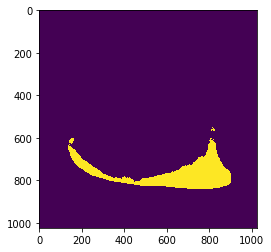

In [16]:
plt.imshow(im)

In [ ]:
sub_df.to_csv('submission/0826_unet_1024_seed9012_tta_v1_6200_020.csv.gz', index=False, compression='gzip')

In [ ]:
(sub_df.EncodedPixels!='-1').mean()

In [ ]:
from scipy import ndimage

In [ ]:
#### Step 2: the sub is Instance Segmentation, so need to split mask into instances of masks
def split_mask(mask):
    MASK_THRESHOLD = 0.2#0.22
    EMPTY_THRESHOLD = 100#30 for IMG_SIZE=256 #ignore predictions composed of 30 pixels or less. This is tunable!!!
    #split disconnected masks with ndimage.label function
    labled,n_objs = ndimage.label(mask > MASK_THRESHOLD)
    result = []
    n_pixels = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if obj.sum() > EMPTY_THRESHOLD:
            result.append(obj)
            n_pixels.append(obj.sum())
    #sort masks based on the number of pixels
    result = [x for _,x in sorted(zip(n_pixels,result),reverse=True,key=lambda x:x[0])]
    return result

In [ ]:
%%time
rles = []
ids_c = []
for p,idx in tqdm_notebook(zip(preds_test, test_fnames), total=len(preds_test)):
    pred_mask = predict_mask(p, EMPTY_THRESHOLD, MASK_THRESHOLD)
    if pred_mask.sum() > 0:
        masks = split_mask(pred_mask)#to_np
        for mask in masks:
            ids_c.append(idx)
            im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((1024,1024))
            im = np.asarray(im)
            rles.append(mask2rle(im, 1024, 1024))
        if len(masks) == 0:
            rles.append('-1')
            ids_c.append(idx)
    else: 
        rles.append('-1')
        ids_c.append(idx)

In [ ]:
sub_df = pd.DataFrame({'ImageId': ids_c, 'EncodedPixels': rles})
print(len(sub_df))
sub_df.head()

In [ ]:
sub_df.to_csv('submission/0712_unet_512_seed1234_split.csv.gz', index=False, compression='gzip')